Using TensorFlow backend.


11321344/11490434 [============================>.] - ETA: 1s(50000, 28, 28) (50000,)


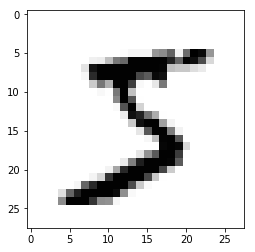

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [5]:
print(X_train.shape)
print(y_train.shape)

(50000, 28, 28)
(50000,)


## Tensorflow

In [3]:
import tensorflow as tf
s = tf.InteractiveSession()

In [23]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
print(X_train_flatten.shape)
print(y_train.shape)
print(y_train[1])

(784, 50000)
(50000,)
0


In [13]:
def one_hot_matrix(labels, C):
    C = tf.constant(C, name='C')
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [24]:
y_train_one_hot = one_hot_matrix(y_train, C=10)
y_val_one_hot = one_hot_matrix(y_val, C=10)
y_test_one_hot = one_hot_matrix(y_test, C=10)
print(y_train_one_hot.shape)
print(str(y_train_one_hot))

(10, 50000)
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [30]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X, Y

In [28]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [100, 784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [100, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [20, 100], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [20, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 20], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1":W1,
                 "b1":b1,
                 "W2":W2,
                 "b2":b2,
                 "W3":W3,
                 "b3":b3}
    return parameters

In [29]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [31]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(784, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print(str(Z3))

Tensor("Add_2:0", shape=(10, ?), dtype=float32)
